# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [79]:
!pip install finance-datareader

In [80]:
import FinanceDataReader as fdr

In [81]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [82]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-10-23,57500,60000,57100,59100,27300780,0.024263
2024-10-24,58200,58500,56600,56600,31499922,-0.042301
2024-10-25,56000,56900,55800,55900,25829315,-0.012367
2024-10-28,55700,58500,55700,58100,27775009,0.039356
2024-10-29,58000,59600,57300,59600,27870639,0.025818


**미국 주식 데이터**도 가져올 수 있습니다.

In [83]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [84]:
apple.tail()

,Open,High,Low,Close,Volume,Adj Close
2024-10-23,234.080002,235.139999,227.759995,230.759995,52287000,230.759995
2024-10-24,229.979996,230.820007,228.410004,230.570007,31109500,230.570007
2024-10-25,229.740005,233.220001,229.570007,231.410004,38802300,231.410004
2024-10-28,233.320007,234.729996,232.550003,233.399994,36028800,233.399994
2024-10-29,233.195007,234.210007,232.320007,233.929993,14328568,233.929993


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [85]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [86]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
2017-01-03,28.950001,29.082500,28.690001,29.037500,115127600,26.921547
2017-01-04,28.962500,29.127501,28.937500,29.004999,84472400,26.891417
2017-01-05,28.980000,29.215000,28.952499,29.152500,88774400,27.028166
2017-01-06,29.195000,29.540001,29.117500,29.477501,127007600,27.329485
2017-01-09,29.487499,29.857500,29.485001,29.747499,134247600,27.579813


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [87]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [88]:
ford.head()

,Open,High,Low,Close,Volume,Adj Close
1980-01-02,1.297609,1.328022,1.287471,1.287471,2044376,0.227506
1980-01-03,1.287471,1.287471,1.267196,1.287471,2816257,0.227506
1980-01-04,1.287471,1.287471,1.272265,1.277334,3038203,0.225714
1980-01-07,1.277334,1.287471,1.267196,1.267196,2251526,0.223923
1980-01-08,1.267196,1.292540,1.257059,1.292540,4069022,0.228401


In [89]:
ford.tail()

,Open,High,Low,Close,Volume,Adj Close
2019-12-20,9.50,9.54,9.44,9.48,50191200,7.699968
2019-12-23,9.50,9.57,9.40,9.44,54784400,7.667479
2019-12-24,9.44,9.49,9.43,9.47,11881600,7.691847
2019-12-26,9.47,9.49,9.43,9.45,28961300,7.675602
2019-12-27,9.45,9.46,9.35,9.36,28272800,7.602500


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [90]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니,

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [91]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [92]:
stock = fdr.DataReader(STOCK_CODE)

In [93]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-07-06,7240,7350,7179,7300,1206852,NaN
2000-07-07,7340,7460,7230,7360,811625,0.008219
2000-07-10,7440,7630,7410,7600,850172,0.032609
2000-07-11,7580,7740,7450,7450,698992,-0.019737
2000-07-12,7520,7660,7460,7640,802868,0.025503


In [94]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-10-23,57500,60000,57100,59100,27300780,0.024263
2024-10-24,58200,58500,56600,56600,31499922,-0.042301
2024-10-25,56000,56900,55800,55900,25829315,-0.012367
2024-10-28,55700,58500,55700,58100,27775009,0.039356
2024-10-29,58000,59600,57300,59600,27870639,0.025818


In [95]:
stock.index

DatetimeIndex(['2000-07-06', '2000-07-07', '2000-07-10', '2000-07-11',
               '2000-07-12', '2000-07-13', '2000-07-14', '2000-07-18',
               '2000-07-19', '2000-07-20',
               ...
               '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-21',
               '2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25',
               '2024-10-28', '2024-10-29'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [96]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [97]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2000-07-06,7240,7350,7179,7300,1206852,NaN,2000,7,6
2000-07-07,7340,7460,7230,7360,811625,0.008219,2000,7,7
2000-07-10,7440,7630,7410,7600,850172,0.032609,2000,7,10
2000-07-11,7580,7740,7450,7450,698992,-0.019737,2000,7,11
2000-07-12,7520,7660,7460,7640,802868,0.025503,2000,7,12


## 시각화

Text(0, 0.5, 'price')

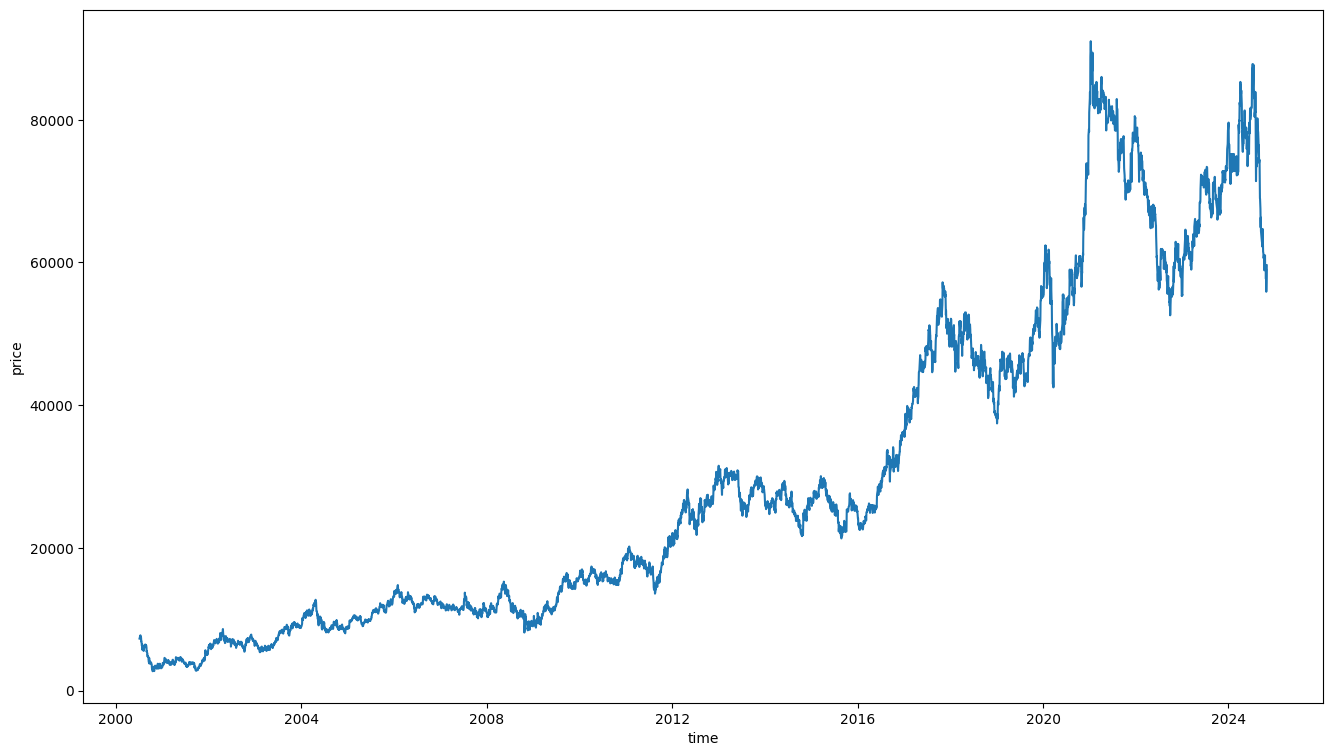

In [98]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

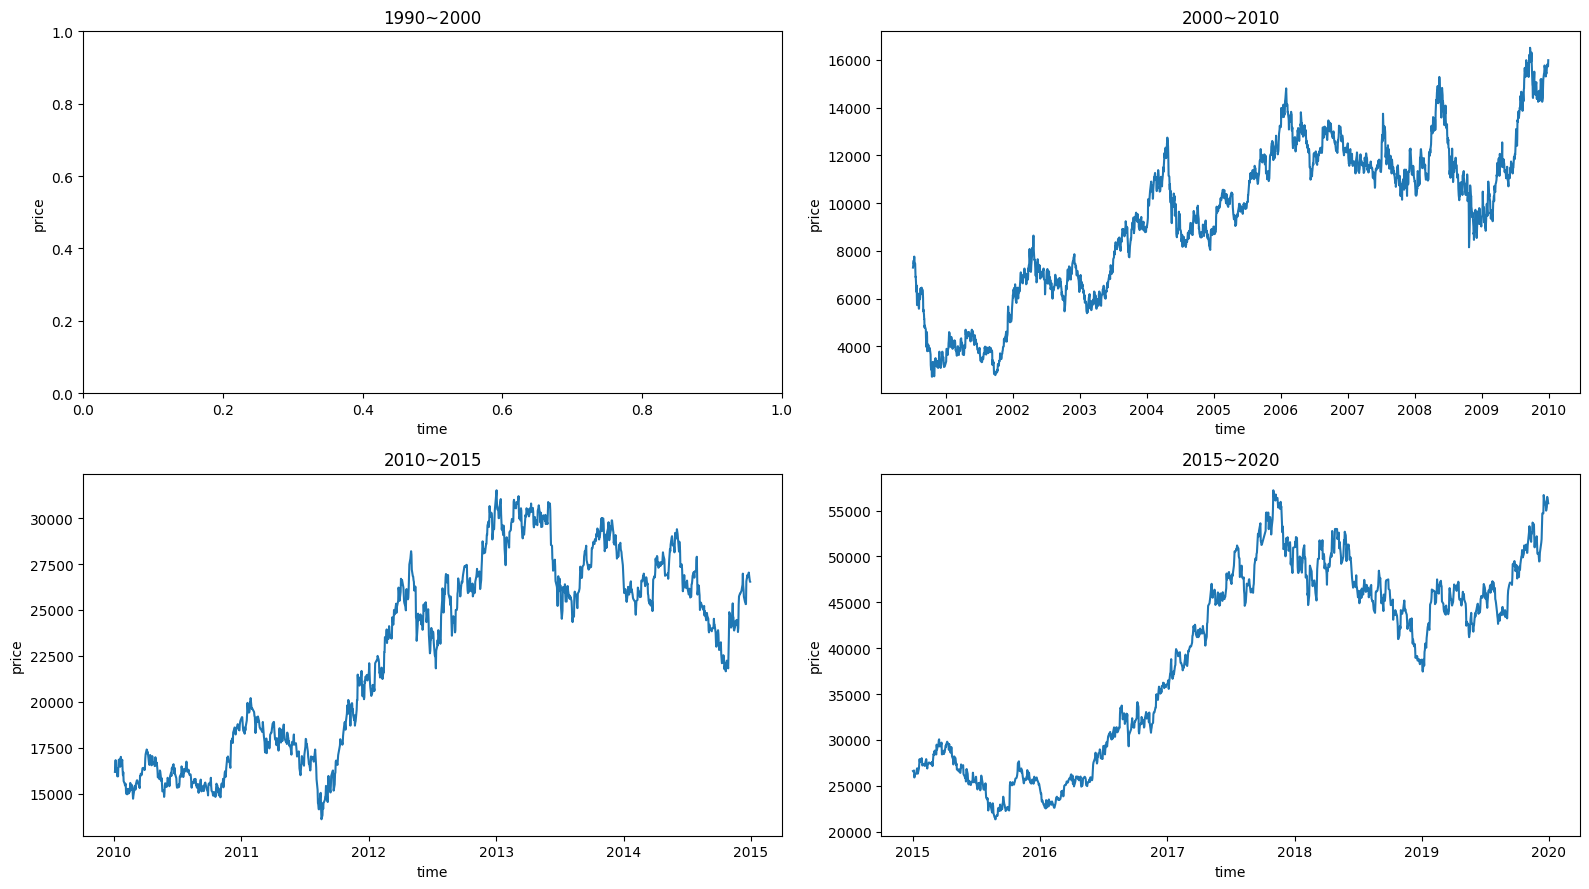

In [99]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [100]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.08017719, 0.07592975, 0.08021229, 0.05177297, 0.013364  ],
       [0.08128461, 0.07706612, 0.08078212, 0.0524527 , 0.00898748],
       [0.08239203, 0.07882231, 0.0827933 , 0.05517163, 0.00941433],
       ...,
       [0.62015504, 0.58780992, 0.62346369, 0.60235641, 0.28601936],
       [0.61683278, 0.60433884, 0.62234637, 0.62727994, 0.30756489],
       [0.64230343, 0.61570248, 0.64022346, 0.64427325, 0.30862384]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [101]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis = 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [104]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [105]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [106]:
x_train

,Open,High,Low,Volume
0,0.080177,0.075930,0.080212,0.013364
1,0.081285,0.077066,0.080782,0.008987
2,0.082392,0.078822,0.082793,0.009414
3,0.083942,0.079959,0.083240,0.007740
4,0.083278,0.079132,0.083352,0.008891
...,...,...,...,...
4795,0.555925,0.520661,0.553073,0.115714
4796,0.554817,0.525826,0.558101,0.126398
4797,0.563677,0.530992,0.566480,0.093799
4798,0.564784,0.533058,0.566480,0.076216


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [107]:
import tensorflow as tf

In [108]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [109]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [110]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [111]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [113]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [114]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.weights.h5')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [77]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown 6s 7ms/step - loss: 4.9029e-04 - mse: 9.8059e-04
Epoch 1: val_loss improved from inf to 0.00548, saving model to tmp/ckeckpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 4.8888e-04 - mse: 9.7776e-04 - val_loss: 0.0055 - val_mse: 0.0110
Epoch 2/50
147/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5952e-05 - mse: 5.1904e-05
Epoch 2: val_loss improved from 0.00548 to 0.00356, saving model to tmp/ckeckpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.6697e-05 - mse: 5.3394e-05 - val_loss: 0.0036 - val_mse: 0.0071
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2027e-05 - mse: 4.4053e-05
Epoch 3: val_loss improved from 0.00356 to 0.00322, saving model to tmp/ckeckpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.2212e-05 - mse: 4.4424e-05 - val_loss: 0.0032 - val_mse: 0.0064
Epoch 4/50
147/150 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1579e-05 - mse: 4.3158e-05
Epoch 4: val_loss improve

저장한 ModelCheckpoint 를 로드합니다.

In [115]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [116]:
pred = model.predict(test_data)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [117]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

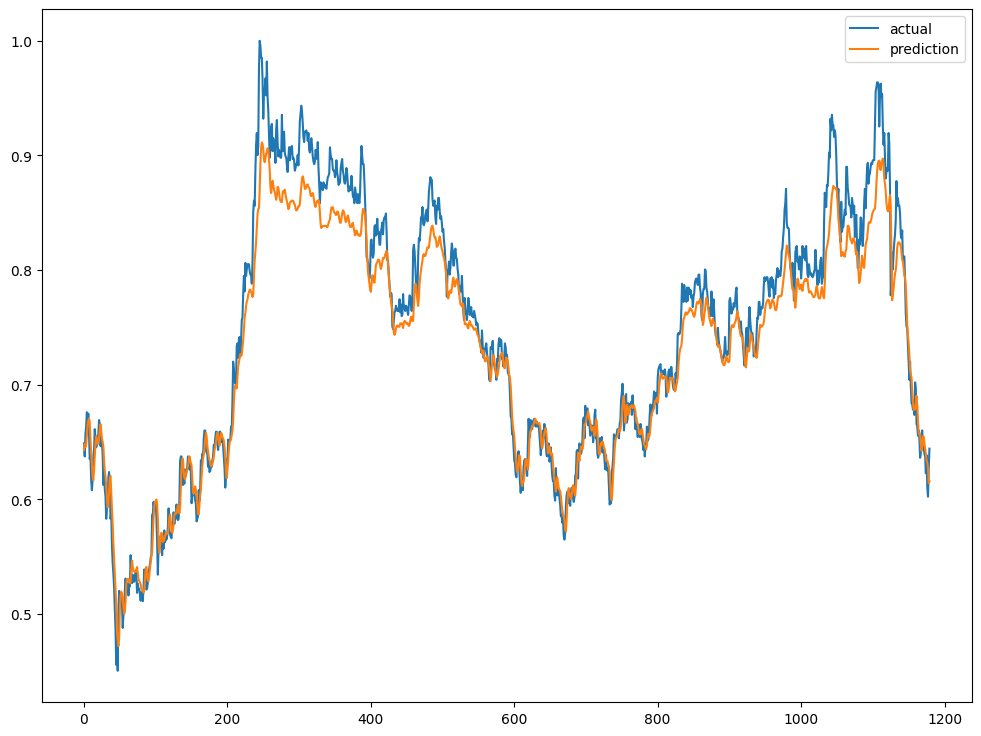

In [118]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()